# LLM Feasibility
After manually creating the dataset of poetry and labeling it, let's just see if it's possible to train a GPT-2 model on the data and get an actual result. This notebook is being run on Kaggle after running into some issues 

# Loading Data and Preprocessing

The dataset I made consists of 30 entries, half being written by me and the other half written by other authors on r/OCPoetry. The label meanings are:
- 1 = Written by me
- 0 = Not written by me 

Before we train, I'll need to convert the literal '\n' characters in the dataset into actual line breaks and split the dataset into training and test sets, then convert them into Hugging Face datasets.

In [4]:
import pandas as pd
import torch
from transformers import GPT2Tokenizer, GPT2ForSequenceClassification, Trainer, TrainingArguments, EarlyStoppingCallback
from datasets import Dataset
import matplotlib.pyplot as plt
import numpy as np

2025-08-11 03:02:58.255385: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1754881378.504751      36 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1754881378.577419      36 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


In [5]:
path = "/kaggle/input/data-csv/data.csv"
df = pd.read_csv(path)
df.head()

,text,labels
0,Flesh craves flesh lingering want\nSkin plaste...,1
1,How does it feel\nTo glide across the diamond ...,1
2,Your wires wrapped around my beating heart\nUn...,1
3,"Oh, you're finally here\nTake me, take me away...",1
4,I dreamed a dream so beautiful it blinded my e...,1


In [7]:
# Function that preprocesses the CSV file and prepares the sets for training
def preprocess(df, shuffle=True):
  # Shuffle the data entries if when making the dataset you didn't mix up the entries like me
  if shuffle:
    df = df.sample(frac=1).reset_index(drop=True)
  
  # Convert the place holder \n characters into actual line breaks
  print("Before conversion:")
  print(df['text'][0])

  df['text'] = df['text'].apply(lambda x: x.replace("\\n", "\n"))

  # Check to see if conversion worked
  print("\nAfter conversion:")
  print(df['text'][0])

  # Split the data into training and test sets
  test = df.sample(frac=0.2, random_state=42)
  train = df.drop(test.index)

  # Check to see if the shapes are correct
  print("\nDataframe sizes:", test.shape, train.shape)
  
  # Convert the CSV files into Hugging Face Datasets for training
  train_dataset = Dataset.from_pandas(train).remove_columns(["__index_level_0__"])
  test_dataset = Dataset.from_pandas(test).remove_columns(["__index_level_0__"])

  print("\n")
  print(train_dataset)
  print(test_dataset)

  return df, train_dataset, test_dataset

In [8]:
df, train_dataset, test_dataset = preprocess(df, shuffle=True)

Before conversion:
Heart strung at the wrists\nUntil you hack at it\nWith your own thoughts and tired hands\nPulled and twisted\nThoughts spin around your head\nYou got what you deserved\nPulled apart by greedy hands\nYou couldn't handle it

After conversion:
Heart strung at the wrists
Until you hack at it
With your own thoughts and tired hands
Pulled and twisted
Thoughts spin around your head
You got what you deserved
Pulled apart by greedy hands
You couldn't handle it

Dataframe sizes: (6, 2) (24, 2)


Dataset({
    features: ['text', 'labels'],
    num_rows: 24
})
Dataset({
    features: ['text', 'labels'],
    num_rows: 6
})


In [9]:
# Ensure the dataframe was shuffled
df.head()

,text,labels
0,Heart strung at the wrists\nUntil you hack at ...,1
1,"""Individuality.""\nThe soldier had it engraved ...",0
2,as a child my mother once found me scraping my...,0
3,Stare into my clouded eyes\nSkin on skin feels...,1
4,Fleeting bird\nrest in my palm\na dying song\n...,0


In [10]:
# Function that tokenizes the plain text datasets for training
def tokenize_text(train_dataset, test_dataset):
    # Load in tokenizer
    tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
    tokenizer.pad_token = tokenizer.eos_token

    # Tokenize the data
    def tokenize_function(examples):
        return tokenizer(examples["text"], padding="max_length", truncation=True, max_length=128)

    # Apply the tokenization
    train_dataset = train_dataset.map(tokenize_function, batched=True)
    test_dataset = test_dataset.map(tokenize_function, batched=True)

    # Format datasets for PyTorch
    train_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])
    test_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "labels"])

    return train_dataset, test_dataset

In [11]:
train_dataset, test_dataset = tokenize_text(train_dataset, test_dataset)

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/1.04M [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

Map:   0%|          | 0/24 [00:00<?, ? examples/s]

Map:   0%|          | 0/6 [00:00<?, ? examples/s]

# Training GPT-2
Given that we're working with such a small dataset, overfitting is a huge risk when training. For now, I'll be freezing all of the layers except for the classification head. Early stopping after 3 epochs of no validation loss improvement will also be addded to prevent overfitting. A weight decay argument will also be added. 

In [12]:
# Load in pre-trained GPT-2 model with a classification head
model = GPT2ForSequenceClassification.from_pretrained("gpt2", num_labels=2)

# Set padding token
tokenizer = GPT2Tokenizer.from_pretrained("gpt2")
model.config.pad_token_id = tokenizer.eos_token_id

# Freeze all parameters
for param in model.parameters():
    param.requires_grad = False

# Unfreeze only the classification head
for param in model.score.parameters():
    param.requires_grad = True

model.safetensors:   0%|          | 0.00/548M [00:00<?, ?B/s]

Some weights of GPT2ForSequenceClassification were not initialized from the model checkpoint at gpt2 and are newly initialized: ['score.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [14]:
# Training arguments
training_args = TrainingArguments(
    output_dir="./results",
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    metric_for_best_model="eval_loss",
    greater_is_better=False,
    learning_rate=1e-6,
    per_device_train_batch_size=2,
    per_device_eval_batch_size=2,
    num_train_epochs=10,
    weight_decay=0.01,
    logging_dir="./logs",
    logging_steps=10,
    report_to="none",
    seed=42
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_dataset,
    eval_dataset=test_dataset,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=3)]
)

trainer.train()

Epoch,Training Loss,Validation Loss
1,0.809900,0.724902
2,0.727900,0.724973
3,0.732500,0.724975
4,0.793100,0.725143


TrainOutput(global_step=48, training_loss=0.758020669221878, metrics={'train_runtime': 54.3265, 'train_samples_per_second': 4.418, 'train_steps_per_second': 2.209, 'total_flos': 6271122014208.0, 'train_loss': 0.758020669221878, 'epoch': 4.0})

# Evaluation

Looking at the graph, the GPT-2 model is learning to generalize, but at a veryyyyy slow rate. The training loss is also very unstable. This is likely due to the small training set and small batch sizes, leading to alot of variance in the training data. This could be improved with more training data, increasing batch sizes, or unfreezing some layers. The training is feasible, but will likely require some major changes to get done properly.

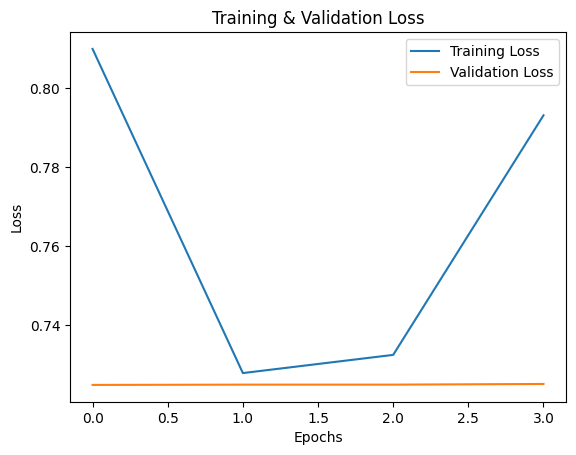

In [15]:
# Extract losses
train_loss = [log["loss"] for log in trainer.state.log_history if "loss" in log]
eval_loss  = [log["eval_loss"] for log in trainer.state.log_history if "eval_loss" in log]

# Plot the training and validation loss 
plt.plot(train_loss, label="Training Loss")
plt.plot(eval_loss, label="Validation Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.title("Training & Validation Loss")
plt.legend()
plt.show()